In [1]:
%matplotlib inline
import nivapy3 as nivapy
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import critical_loads as cl
import statsmodels.formula.api as sm

plt.style.use('ggplot')

In [2]:
# Connect to Docker PostGIS
eng = nivapy.da.connect(src='postgres',
                        db_name='critical_loads',
                        port = 25432)

Connection successful.


# Critical loads for vegetation (high-resolution method; 2018 onwards)

In Spring 2018, the worflow for calculating critical loads for vegetation [was refined](http://nbviewer.jupyter.org/github/JamesSample/critical_loads/blob/master/notebooks/critical_loads_workflow_new_grid.ipynb#1.-Vegetation) to make use of new, higher-resolution input datasets. During November 2018, data handling for the Critical Loads project was also redesigned, with the ultimate aim of centralising and migrating all key datasets onto NIVA's new cloud platform. This notebook estimates exceedences of critical loads for vegetation using both the revised (Spring 2018) workflow and the new (November 2018) data structures. Calculations here assume that deposition data are supplied using NILU's 0.1 degree grid, and the vegetation map is based on 30 m resolution **raster** satellite imagery.

**Note:** Data supplied prior to 2017-18 use a different deposition grid (the "BLR" grid) and vector vegetation data. **The workflow described here only applies to data supplied from 2017-18 onwards**; earlier data is *not* compatible with the calculations described here.    

**To do:** Create a notebook to repeat the old workflow as well.

## 1. Deposition data

The first step, if desired, is to upload new deposition data from NILU for the time period of interest.

### 1.1. Define a new deposition series (optional)

The code below extracts the existing deposition series already defined in the database. Click `'Add row'` to create a new row at the bottom of the table (initially a duplicate of the last row), then double-click to edit values and define the new data series. Note that all columns are mandatory.

In [3]:
# Define a new deposition series
ser_grid = cl.view_dep_series(eng)
ser_grid

Click 'Add Row', then edit the last row in the table to reflect the new data you wish to upload.


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
# Add new series to database
add_df = cl.add_dep_series(ser_grid, eng)
add_df

### 1.2. Upload deposition data (optional)

In 2017, NILU supplied raw data for the 0.1 degree grid in `.dat` format. The code here assumes new data are supplied in the same way.

Modify the user options in the cell below to match your new data:

 * `ser_id` is the ID of the new row that was added to the table above
 
 * `dat_fold` is the *relative* path to a folder containing **only** the `.dat` files you wish to upload

In [4]:
# series_id to upload
ser_id = 28

# Folder containing .dat files
dat_fold = r'../../../data/raw/nilu_dep/2012-2016'

assert ser_id > 27, ('ERROR: The workflow in this notebook is only compatible with recent datasets '
                     'using the 0.1 degree NILU deposition grid. For older datasets, see notebook 2.')

In [ ]:
# Process NILU data and add to db
df = cl.upload_nilu_0_1deg_dep_data(dat_fold, eng, ser_id)
df.head()

### 1.3. Map N deposition data

The code below generates a choropleth map of the N deposition data (used for the vegetation calculations).

In [3]:
# series_id to work with
ser_id = 28

# Get dep data from database
dep_gdf = cl.n_deposition_as_gdf_0_1deg(ser_id, eng)
dep_gdf.head()

,geom,cell_id,n_dep
0,(POLYGON ((5655.001419191016 6470694.353263143...,58050655,840.0
1,(POLYGON ((9788.008778641524 6465964.999440175...,58050665,911.0
2,"(POLYGON ((17388.7264354463 6469241.096078512,...",58050675,1014.0
3,(POLYGON ((22572.27425884473 6462862.544306678...,58050685,1070.0
4,"(POLYGON ((27984.3201594979 6458257.534750269,...",58050695,1108.0


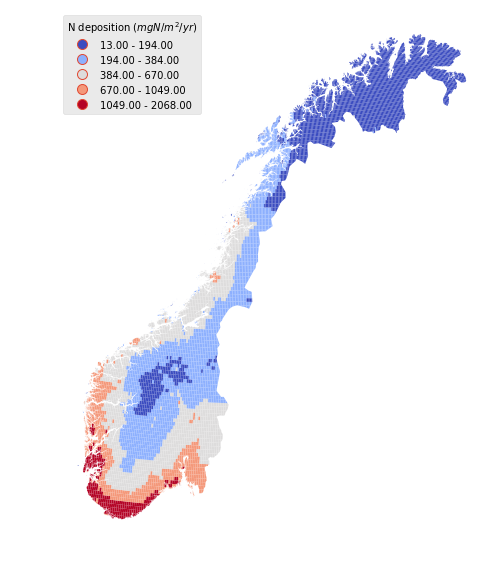

In [5]:
# Choropleth map
dep_gdf.plot(column='n_dep', 
             cmap='coolwarm',
             scheme='fisher_jenks',
             edgecolor=None,
             legend=True,
             legend_kwds={'loc':'upper left',
                          'title': 'N deposition ($mgN/m^2/yr$)'},
             figsize=(8,8))

plt.axis('off')
plt.tight_layout()

## 2. Critical loads for vegetation

The code below extracts raster vegetation data from the database and reclassifies it based on a table of critical loads. It is not necessary to re-run this step unless the critical loads for vegetation are changed. Reclassified grids using the current CL values are already available directly from the database.

**Note:** The function `cl.reclassify_raster()` requires specification of a `mask_tif` to define the land. This is because the vegetation data includes offshore regions classified as `'water'`, and we do not wish to include these in the CL calculations. The database includes two possible mask grids (30 m and 60 m), both based on the extent of the old BLR grid. In Section 2.2, choose the one that matches the resolution of the vegetation data you wish to work with.

### 2.1. Extract vegetation raster

In [8]:
## Extract 60m raster vegetation data
#veg_tif = r'../../../data/raster/vegetation_60m.tif'
#nivapy.da.postgis_raster_to_geotiff('critical_loads',
#                                    'host.docker.internal',
#                                    25432,
#                                    'vegetation',
#                                    'sat_veg_60m_all',
#                                    veg_tif)

### 2.2. Extract mask grid for land

In [9]:
## Extract 60m land mask based on the BLR grid
#mask_tif = r'../../../data/raster/mask_60m.tif'
#nivapy.da.postgis_raster_to_geotiff('critical_loads',
#                                    'host.docker.internal',
#                                    25432,
#                                    'vegetation',
#                                    'blr_land_mask_60m',
#                                    mask_tif)

### 2.3. Reclassify

In [10]:
## Read reclassification table from db
#sql = ("SELECT * FROM vegetation.land_class_crit_lds")
#rc_df = pd.read_sql(sql, eng)
#
## Set land class code as index
#rc_df.index = rc_df['norut_code']
#del rc_df['norut_code']
#
#rc_df

,norut_veg_class,eunis_code,eunis_veg_class,comment,cl_meq_m2_yr,cl_100smgn_m2_yr,cl_mgn_m2_yr
norut_code,,,,,,,
1,Barskog - tett tresjikt,G3,Coniferous woodland,None,35.714286,5,500
2,Barskog og blandingsskog - åpent tresjikt,G4.2,Mixed taiga woodland with Betula,None,35.714286,5,500
3,Lavrik furuskog,G3.B,Pine taiga woodland,None,35.714286,5,500
4,Lågurtskog og edellauvskog,G1,Broadleaved deciduous woodland,None,71.428571,10,1000
5,Høgstaude- og storbregnelauvskog,G1,Broadleaved deciduous woodland,None,71.428571,10,1000
6,Blåbær- og småbregnebjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
7,Kreklingbjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
8,Lavrik bjørkeskog,G1.918,Eurasian boreal Betula woods,None,35.714286,5,500
9,Tuemyr og lågvokst fastmattemyr,D1,Raised- and blanket bogs,None,35.714286,5,500


In [11]:
## Reclassify
#rc_tif = r'../../../data/raster/veg_cl_div100_60m.tif'
#cl.reclassify_raster(veg_tif,
#                     mask_tif,
#                     rc_tif,
#                     rc_df,
#                     'cl_100smgn_m2_yr',
#                     255)

### 2.4. Add new critical loads grid to database

In [ ]:
## Add CL grid to PostGIS
#nivapy.da.raster_to_postgis(rc_tif,
#                            'critical_loads',
#                            'vegetation',
#                            'veg_cl_div100_60m', 
#                            32633)

## 3. Exceedances for vegetation

Exceedances for vegatation are calculated as follows:

 1. Convert the vector deposition data to a raster with the same properties (extent, cell size etc.) as the critical loads grid
 
 2. Calculate the exceedance for each pixel, $i$, as $E_i = D_i - C_i$ (where $E$ is exceedance, $D$ is deposition and $C$ is the critical load)
 
 3. Save the exceedance grid as a GeoTiff. Calculate the total exceeded area for Norway as a whole, the proportion exceeded for each land class, and the proportion exceeded in each 0.1 degree vector cell
 
 4. Write the results (i.e. the exceedance raster and the table & vector summaries) back to the database
 
### 3.1. Extract raster of critical loads

If the current raster of critial loads is not already available on your system, it can be extracted from the database using the code in the cell immediately below.

**Note:** The analysis undertaken during spring 2018 made use of a 30 m resolution vegetation grid. The same grid could be used here if desired, but the calculations are slow and also at the limit of what my laptop can fit in memory while running Docker. For the work here, I have therefore decided to use the 60 m resolution vegetation grid, because this gives essentailly the same output and is much faster for testing & development. On Google Cloud, memory should not be an issue, so it will be possible for the user to choose between 30 m and 60 m resolution datasets simply by modifying the code in the cells below.

Note also that, at present, the relevant rasters are available on the NIVA network here 

    K:\Prosjekter\JES\Critical_Loads\GIS\Raster
    
It is probably quicker to copy the rasters from this network folder to a location on your system, rather than extracting (and decompressing) them from PostGIS.

In [ ]:
## Extract raster of CLs to .tif
## .tif to create
#cl_tif = r'../../../data/raster/sat_veg_60m_cr_lds_div100.tif'
#
## Get data from db
#nivapy.da.postgis_raster_to_geotiff('critical_loads',
#                                    'host.docker.internal',
#                                    25432,
#                                    'vegetation',
#                                    'sat_veg_60m_cr_lds_div100',
#                                    cl_tif)

### 3.2. Calculate exceedance

The code below first converts the deposition data (from Section 1.3, above) into a GeoTiff matching the critical loads grid. The critical loads and deposition grids are then combined to estimate exceedances, and summary results at national scale (total area exceeded etc.) are saved back to the database.

**Note:** Deposition values for each grid cell will be rounded to the nearest integer (mgN/m2/year) and the grid saved in 16-bit integer format. This keeps file sizes manageable but, nevertheless, this step is computationally intensive and quite slow.

In [6]:
# CL raster (created in Section 2.1)
cl_tif = r'../../../data/raster/sat_veg_60m_cr_lds_div100.tif'

# Output deposition .tif to create
dep_tif = r'../../../data/raster/ndep_12-16_60m.tif'

# Output exceedance .tifs to create
ex_tif = r'../../../data/raster/veg_ex_12-16_60m.tif'
ex_tif_bool = r'../../../data/raster/veg_ex_12-16_60m_bool.tif'

In [7]:
# Create a deposition raster
cl.create_n_deposition_raster_0_1deg(ser_id, dep_tif, cl_tif, eng, ndv=-1)

# Calculate exceedance
ex_df = cl.calc_vegetation_exceedance_0_1deg(dep_tif, cl_tif, ex_tif, ex_tif_bool, ser_id)

ex_df

/home/jovyan/work/new_workflow_nov_2018/python/critical_loads_2/notebooks/critical_loads.py:451: RuntimeWarning: invalid value encountered in greater
  ex_area = np.count_nonzero(ex_grid > 0)*cs*cs/1.E6
/home/jovyan/work/new_workflow_nov_2018/python/critical_loads_2/notebooks/critical_loads.py:454: RuntimeWarning: invalid value encountered in less
  ex_grid[ex_grid<0] = 0


,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct
0,28,vegetation,322185,61806,19


In [8]:
# Write summary data to db
ex_df.to_sql('national_summary', 
             eng,
             'summaries',
             if_exists='append',
             index=False)

In [9]:
# Add 60m exceedance grid to PostGIS
nivapy.da.raster_to_postgis(ex_tif,
                            'critical_loads',
                            'vegetation',
                            'veg_ex_12-16_60m', 
                            32633)


Processing data for vegetation.veg_ex_12-16_60m...

Raster loaded successfully.


In [10]:
# Add 60m boolean exceedance grid to PostGIS
nivapy.da.raster_to_postgis(ex_tif_bool,
                            'critical_loads',
                            'vegetation',
                            'veg_ex_12-16_60m_bool', 
                            32633)


Processing data for vegetation.veg_ex_12-16_60m_bool...

Raster loaded successfully.


### 3.3 Zonal statistics

#### 3.3.1. Exceedance per 0.1 degree grid cell

The code below calculates exceedance summary statistics for each 0.1 degree grid cell. Results are saved back to the database.

In [11]:
# Calculate zonal statistics
gdf = cl.exceedance_stats_per_0_1deg_cell(ex_tif_bool, 
                                          ser_id, 
                                          eng, 
                                          categorical=True,
                                          category_map={1:'exceeded',
                                                        0:'not_exceeded'},
                                          nodata_value=255)

#### 3.3.2. Exceedance per land use class

In [13]:
# Calc exceedance per land cover class
veg_tif = r'../../../data/raster/sat_veg_60m_all.tif'
df = cl.exceedance_stats_per_land_use_class(ex_tif_bool, 
                                            veg_tif, 
                                            ser_id,
                                            eng,
                                            nodata_value=255)

df

,norut_code,series_id,exceeded_area_km2,total_area_km2,pct_exceeded
0,1,28,11658.3228,28679.3712,40.650552
1,2,28,6834.5100,16574.1768,41.235894
2,3,28,4211.5104,11406.5064,36.922001
3,4,28,1526.3748,18095.6088,8.435056
4,5,28,1181.6784,17810.3340,6.634791
5,6,28,3726.1152,14855.2236,25.082862
6,7,28,1744.6824,9022.9212,19.336115
7,8,28,1272.3300,6777.7668,18.772112
8,9,28,1412.4024,7994.7252,17.666679
9,10,28,220.2120,5931.6768,3.712475


### 3.4. View results per 0.1 degree grid square

In [14]:
# Extract exceedance summaries
ex_gdf = cl.veg_exceedance_as_gdf_0_1deg(ser_id, eng)

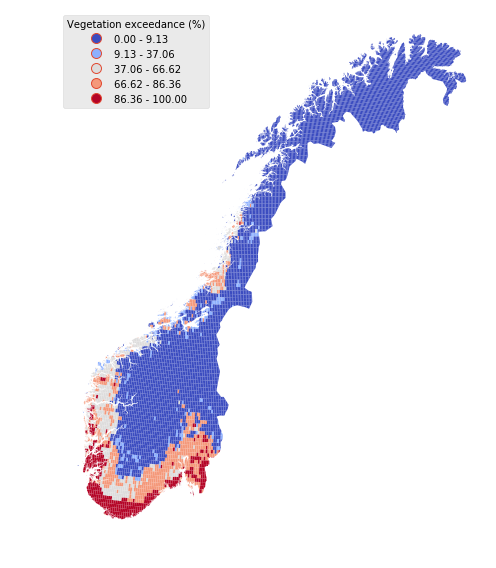

In [15]:
# Choropleth map
ex_gdf.plot(column='pct_exceeded', 
            cmap='coolwarm',
            scheme='fisher_jenks',
            edgecolor=None,
            legend=True,
            legend_kwds={'loc':'upper left',
                         'title': 'Vegetation exceedance (%)'},
            figsize=(8,8))

plt.axis('off')
plt.tight_layout()